In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import random

from ..src.data_pipeline import random_test_patches_mask

## Model loading

In [2]:
class MaskedAutoEncoder(nn.Module):
    def __init__(self, in_dim=9, maskable_dim=4, embed_dim=64, depth=4):
        super().__init__()
        self.in_dim = in_dim
        self.maskable_dim = maskable_dim

        self.mask_token = nn.Parameter(torch.zeros(in_dim))

        layers = []
        for _ in range(depth):
            layers += [
                nn.Linear(embed_dim if layers else in_dim, embed_dim),
                nn.GELU(),
                nn.LayerNorm(embed_dim)
            ]
        self.encoder = nn.Sequential(*layers)

        self.decoder = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.Linear(embed_dim, in_dim)
        )

    def forward(self, x, mask):
        x = torch.where(mask, x, self.mask_token)
        z = self.encoder(x)
        return self.decoder(z)

In [11]:
MODEL_PATH = '../models/model.pt'

In [12]:
if os.path.exists(MODEL_PATH):
    print(f"Loading model from {MODEL_PATH}")
    model = MaskedAutoEncoder(in_dim=9, embed_dim=128).cuda()
    model.load_state_dict(torch.load(MODEL_PATH))
    model.eval()
else:
    print(f"MAE model not found!")

Loading model from ../models/model.pt


## Data loading

In [34]:
def random_test_patches_mask(df: pd.DataFrame, grid_size=(20, 20), n_patches=10, seed=42) -> pd.Series:
    """
    Losuje n_patches z globalnej siatki i tworzy maskę testową.
    
    Args:
        df: DataFrame z kolumnami 'lat' i 'lon'.
        grid_size: (n_lat_bins, n_lon_bins) – ile kafli w pionie i poziomie.
        n_patches: ile patchy ma trafić do testu.
        seed: dla powtarzalności.

    Returns:
        test_mask: pd.Series[bool] z True dla testowych patchy.
    """
    lat_bins = np.linspace(df["lat"].min(), df["lat"].max(), grid_size[0] + 1)
    lon_bins = np.linspace(df["lon"].min(), df["lon"].max(), grid_size[1] + 1)

    lat_inds = np.digitize(df["lat"], bins=lat_bins) - 1
    lon_inds = np.digitize(df["lon"], bins=lon_bins) - 1

    patch_ids = lat_inds * grid_size[1] + lon_inds
    df = df.copy()
    df["patch_id"] = patch_ids

    unique_patches = df["patch_id"].unique()
    rng = np.random.default_rng(seed)
    test_patch_ids = rng.choice(unique_patches, size=n_patches, replace=False)

    test_mask = df["patch_id"].isin(test_patch_ids)
    return test_mask

In [37]:
df = pd.read_parquet("../data/processed/nitrate_00_train_data.parquet")
cols = ["temperature_00", "salinity_00", "oxygen_00", "phosphate_00"]

def encode_geospatial_features(df: pd.DataFrame) -> np.ndarray:
    lat_rad = np.radians(df["lat"].to_numpy())
    lon_rad = np.radians(df["lon"].to_numpy())

    sin_lat = np.sin(lat_rad)
    cos_lat = np.cos(lat_rad)
    sin_lon = np.sin(lon_rad)
    cos_lon = np.cos(lon_rad)

    depth = df["depth"].to_numpy(dtype=np.float32)
    norm_depth = (depth - depth.min()) / (depth.max() - depth.min())

    geo_features = np.stack([sin_lat, cos_lat, sin_lon, cos_lon, norm_depth], axis=1)
    return geo_features.astype(np.float32)

class Scaler:
    def __init__(self, mean: dict[str, float], std: dict[str, float]):
        self.mean = mean
        self.std = std
        self.cols = list(mean.keys())

    @classmethod
    def from_dataframe(cls, df, cols):
        mean = {col: df[col].mean() for col in cols}
        std = {col: df[col].std() for col in cols}
        return cls(mean, std)

    def normalize(self, tensor: torch.Tensor, cols: list[str]) -> torch.Tensor:
        for i, col in enumerate(cols):
            tensor[:, i] = (tensor[:, i] - self.mean[col]) / self.std[col]
        return tensor

    def denormalize(self, tensor: torch.Tensor, cols: list[str]) -> torch.Tensor:
        means = torch.tensor([self.mean[c] for c in cols], dtype=tensor.dtype, device=tensor.device)
        stds  = torch.tensor([self.std[c]  for c in cols], dtype=tensor.dtype, device=tensor.device)
        return tensor * stds + means

    def mae(self, reconstructed: torch.Tensor, ground_truth: torch.Tensor, cols: list[str]) -> float:
        rec_denorm = self.denormalize(reconstructed.clone(), cols)
        gt_denorm = self.denormalize(ground_truth.clone(), cols)
        return torch.abs(rec_denorm - gt_denorm).mean().item()

    def masked_mae(self, reconstructed: torch.Tensor, ground_truth: torch.Tensor, mask: torch.Tensor, cols: list[str]) -> float:
        rec_denorm = self.denormalize(reconstructed.clone(), cols)
        gt_denorm = self.denormalize(ground_truth.clone(), cols)

        abs_error = torch.abs(rec_denorm - gt_denorm)
        masked_error = abs_error * mask

        mae = masked_error.sum() / mask.sum().clamp(min=1.0)
        return mae.item()

df = df.dropna(subset=cols).reset_index(drop=True)
scaler = Scaler.from_dataframe(df, cols)
geo = encode_geospatial_features(df)
x = df[cols].to_numpy(dtype=np.float32)

x_full = np.concatenate([x, geo], axis=1)

X = torch.tensor(x_full)
X = scaler.normalize(X.clone(), cols)

class PredictionDataset(Dataset):
    def __init__(self, X: torch.Tensor, y: torch.Tensor):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

TARGET         = "nitrate_00"
TEST_BBOX      = {                       # Morze Śródziemne
    "lat_min": 30.0, "lat_max": 46.0,
    "lon_min": -6.0, "lon_max": 36.0
}
SEED           = 42
N_JOBS         = -1
SUB_FRAC       = 0.20

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

test_mask = random_test_patches_mask(df, grid_size=(20, 20), n_patches=10)

X_train_large = X[~test_mask, :].clone()
X_test = X[test_mask, :].clone()

y_train_large = df[~test_mask][TARGET].to_numpy(dtype=np.float32)
y_test = df[test_mask][TARGET].to_numpy(dtype=np.float32)

print(f"X_train_large shape: {X_train_large.shape}")
print(f"y_train_large  shape: {y_train_large.shape}")

idx = np.random.choice(X_train_large.shape[0], int((X_train_large.shape[0])*SUB_FRAC), replace=False)

X_train = torch.Tensor(X_train_large[idx])
y_train = torch.Tensor(y_train_large[idx])

print(f"X_train shape: {X_train.shape}")
print(f"X_test  shape: {X_test.shape}")

print(f"y_train shape: {y_train.shape}")
print(f"y_test  shape: {y_test.shape}")

train_ds = PredictionDataset(X_train, y_train)
test_ds  = PredictionDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=len(test_ds), shuffle=False)


X_train_large shape: torch.Size([592390, 9])
y_train_large  shape: (592390,)
X_train shape: torch.Size([118478, 9])
X_test  shape: torch.Size([17522, 9])
y_train shape: torch.Size([118478])
y_test  shape: (17522,)


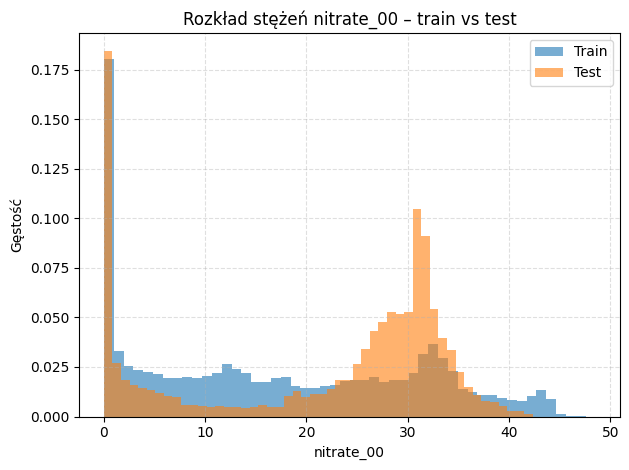

In [39]:
plt.hist(y_train.numpy(), bins=50, alpha=0.6, label='Train', density=True)
plt.hist(y_test, bins=50, alpha=0.6, label='Test', density=True)
plt.legend()
plt.title("Rozkład stężeń nitrate_00 – train vs test")
plt.xlabel("nitrate_00")
plt.ylabel("Gęstość")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

C:\Users\dosti\AppData\Local\Temp\ipykernel_21208\2115757900.py:9: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
d:\Coding\Venvs\DataScience\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


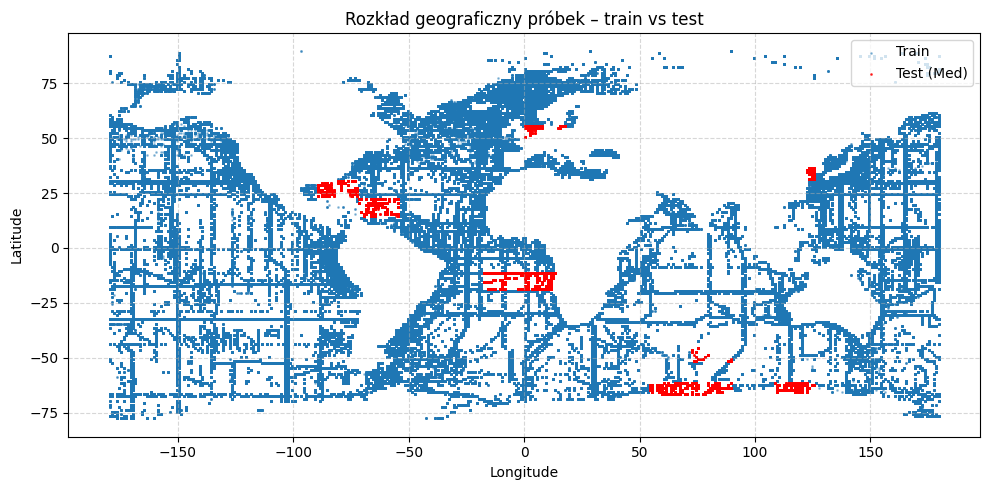

In [40]:
plt.figure(figsize=(10,5))
plt.scatter(df[~test_mask]["lon"], df[~test_mask]["lat"], s=1, label="Train", alpha=0.4)
plt.scatter(df[test_mask]["lon"], df[test_mask]["lat"], s=1, label="Test (Med)", alpha=0.7, color="red")
plt.legend()
plt.title("Rozkład geograficzny próbek – train vs test")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

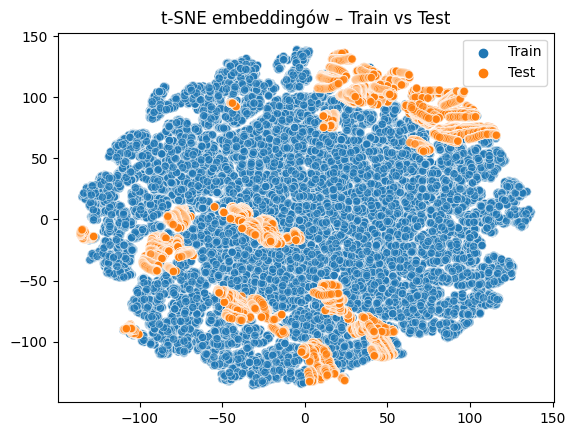

In [41]:
from sklearn.manifold import TSNE

embeddings_train = model.encoder(X_train.cuda()).detach().cpu().numpy()
embeddings_test  = model.encoder(X_test.cuda()).detach().cpu().numpy()

emb_all = np.vstack([embeddings_train, embeddings_test])
labels  = np.array(["Train"] * len(embeddings_train) + ["Test"] * len(embeddings_test))

emb_2d = TSNE().fit_transform(emb_all)

import seaborn as sns
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=labels, alpha=0.6)
plt.title("t-SNE embeddingów – Train vs Test")
plt.show()

## Training loop

In [42]:
def train(model_, loader_, n_epochs=20, lr=1e-3, weight_decay=1e-4, verbose=True, gradient_clipping=False):
    opt = torch.optim.Adam(model_.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=n_epochs)
    loss_fn = nn.MSELoss()

    for epoch in range(n_epochs):
        model_.train()
        total_loss = 0
        all_y = []
        all_pred = []

        for x, y in loader_:
            x, y = x.cuda(), y.cuda()
            pred = model_(x).flatten()

            loss = loss_fn(pred, y)
            loss.backward()

            if gradient_clipping:
                torch.nn.utils.clip_grad_norm_(model_.parameters(), max_norm=1.0)

            opt.step()
            opt.zero_grad()

            total_loss += loss.item()
            all_y.append(y.detach().cpu())
            all_pred.append(pred.detach().cpu())

        scheduler.step()

        # Concatenate all predictions and targets
        all_y = torch.cat(all_y).numpy()
        all_pred = torch.cat(all_pred).numpy()

        r2 = r2_score(all_y, all_pred)
        avg_loss = total_loss / len(loader_)

        if verbose:
            print(f"Epoch {epoch+1}: loss = {avg_loss:.4f}  R2 = {r2:.4f}")

    return avg_loss, r2

def metrics(name, y, pred, verbose=True):
    mse = mean_squared_error(y, pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y, pred)
    r2   = r2_score(y, pred)
    if verbose:
        print(f"{name:<18} RMSE={rmse:.4f} MSE={mse:.4f} MAE={mae:.4f} R2={r2:.4f}")
    return mse, rmse, mae, r2



def evaluate(name, model_, loader_):
    model_.eval()
    for x, y in loader_:
        x, y = x.cuda(), y.cuda()
        pred = model_(x).flatten()
        y = y.detach().cpu().numpy()
        pred = pred.detach().cpu().numpy()
        return metrics(name, y, pred)


def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LayerNorm):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)

## Sanity check: linear prediction without embeddings

In [43]:
class BaselineMLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.predictor = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.predictor(x).squeeze(-1)

for _ in range(1):
    torch.manual_seed(42); torch.cuda.manual_seed_all(42)
    pred_model = BaselineMLP(in_dim=9).cuda()
    _ = train(pred_model, train_loader, n_epochs=13, lr=1e-3, verbose=False)
    _ = evaluate("Baseline", pred_model, test_loader)

Baseline           RMSE=1.6985 MSE=2.8849 MAE=1.1133 R2=0.9827


## Simple linear prediction

In [44]:
class LinearPredictionModel(nn.Module):
    def __init__(self, in_dim, mae):
        super().__init__()
        self.mae = mae
        self.predictor = nn.Linear(in_dim, 1)

        for param in self.mae.parameters():
            param.requires_grad = False

    def forward(self, x):
        enc = self.mae.encoder(x)
        return self.predictor(enc)

torch.manual_seed(42); torch.cuda.manual_seed_all(42)
pred_model = LinearPredictionModel(in_dim=128, mae=model).cuda()
pred_model.predictor.apply(initialize_weights)
_ = train(pred_model, train_loader, n_epochs=30, lr=1e-4)

Epoch 1: loss = 428.3701  R2 = -1.3270
Epoch 2: loss = 392.3034  R2 = -1.1310
Epoch 3: loss = 358.8295  R2 = -0.9493
Epoch 4: loss = 327.9022  R2 = -0.7812
Epoch 5: loss = 299.4074  R2 = -0.6265
Epoch 6: loss = 273.3067  R2 = -0.4846
Epoch 7: loss = 249.4852  R2 = -0.3552
Epoch 8: loss = 227.8080  R2 = -0.2376
Epoch 9: loss = 208.2332  R2 = -0.1311
Epoch 10: loss = 190.5698  R2 = -0.0352
Epoch 11: loss = 174.7556  R2 = 0.0507
Epoch 12: loss = 160.6549  R2 = 0.1272
Epoch 13: loss = 148.1668  R2 = 0.1951
Epoch 14: loss = 137.1376  R2 = 0.2551
Epoch 15: loss = 127.4464  R2 = 0.3077
Epoch 16: loss = 119.0142  R2 = 0.3535
Epoch 17: loss = 111.6878  R2 = 0.3933
Epoch 18: loss = 105.3903  R2 = 0.4275
Epoch 19: loss = 100.0261  R2 = 0.4566
Epoch 20: loss = 95.4981  R2 = 0.4812
Epoch 21: loss = 91.7286  R2 = 0.5017
Epoch 22: loss = 88.6388  R2 = 0.5185
Epoch 23: loss = 86.1617  R2 = 0.5320
Epoch 24: loss = 84.2110  R2 = 0.5425
Epoch 25: loss = 82.7300  R2 = 0.5506
Epoch 26: loss = 81.6712  R2 =

In [45]:
_ = evaluate("Linear prediction", pred_model, test_loader)

Linear prediction  RMSE=10.0675 MSE=101.3544 MAE=8.8683 R2=0.3929


## Multi-layer linear prediction

In [46]:
class MultiLinearPredictionModel(nn.Module):
    def __init__(self, in_dim, mae):
        super().__init__()
        self.mae = mae
        self.predictor = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        for param in self.mae.parameters():
            param.requires_grad = False

    def forward(self, x):
        enc = self.mae.encoder(x)
        return self.predictor(enc)

torch.manual_seed(42); torch.cuda.manual_seed_all(42)
pred_model = MultiLinearPredictionModel(in_dim=128, mae=model).cuda()
pred_model.predictor.apply(initialize_weights)
_ = train(pred_model, train_loader, n_epochs=20, lr=1e-4)

Epoch 1: loss = 336.7257  R2 = -0.8294
Epoch 2: loss = 97.4433  R2 = 0.4705
Epoch 3: loss = 20.8708  R2 = 0.8866
Epoch 4: loss = 12.2215  R2 = 0.9336
Epoch 5: loss = 10.0700  R2 = 0.9453
Epoch 6: loss = 8.7273  R2 = 0.9526
Epoch 7: loss = 7.8269  R2 = 0.9575
Epoch 8: loss = 7.2117  R2 = 0.9608
Epoch 9: loss = 6.7730  R2 = 0.9632
Epoch 10: loss = 6.4435  R2 = 0.9650
Epoch 11: loss = 6.1970  R2 = 0.9663
Epoch 12: loss = 6.0134  R2 = 0.9673
Epoch 13: loss = 5.8729  R2 = 0.9681
Epoch 14: loss = 5.7661  R2 = 0.9687
Epoch 15: loss = 5.6864  R2 = 0.9691
Epoch 16: loss = 5.6281  R2 = 0.9694
Epoch 17: loss = 5.5880  R2 = 0.9696
Epoch 18: loss = 5.5636  R2 = 0.9698
Epoch 19: loss = 5.5498  R2 = 0.9699
Epoch 20: loss = 5.5448  R2 = 0.9699


In [47]:
_ = evaluate("Multi-layer linear prediction", pred_model, test_loader)

Multi-layer linear prediction RMSE=2.4669 MSE=6.0858 MAE=1.7355 R2=0.9635


## Linear+Dropout prediction

In [48]:
class DropoutLinearPredictionModel(nn.Module):
    def __init__(self, in_dim, mae, dropout=0.3):
        super().__init__()
        self.mae = mae
        self.predictor = nn.Sequential(
            nn.LayerNorm(in_dim),
            nn.Linear(in_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),           # Reduced from 0.5 to avoid underfitting
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(dropout / 2),       # Add dropout between deeper layers
            nn.Linear(64, 1)
        )

        for param in self.mae.parameters():
            param.requires_grad = False

    def forward(self, x):
        enc = self.mae.encoder(x)
        return self.predictor(enc)

torch.manual_seed(42); torch.cuda.manual_seed_all(42)
pred_model = DropoutLinearPredictionModel(in_dim=128, mae=model).cuda()
pred_model.predictor.apply(initialize_weights)
_ = train(pred_model, train_loader, n_epochs=20, lr=1e-4, gradient_clipping=True)

Epoch 1: loss = 96.9956  R2 = 0.4729
Epoch 2: loss = 9.8479  R2 = 0.9465
Epoch 3: loss = 8.7692  R2 = 0.9524
Epoch 4: loss = 8.3582  R2 = 0.9546
Epoch 5: loss = 8.1245  R2 = 0.9559
Epoch 6: loss = 7.9278  R2 = 0.9569
Epoch 7: loss = 7.7847  R2 = 0.9577
Epoch 8: loss = 7.6187  R2 = 0.9586
Epoch 9: loss = 7.5967  R2 = 0.9587
Epoch 10: loss = 7.4907  R2 = 0.9593
Epoch 11: loss = 7.4609  R2 = 0.9595
Epoch 12: loss = 7.4275  R2 = 0.9597
Epoch 13: loss = 7.3569  R2 = 0.9600
Epoch 14: loss = 7.3699  R2 = 0.9600
Epoch 15: loss = 7.2493  R2 = 0.9606
Epoch 16: loss = 7.2619  R2 = 0.9606
Epoch 17: loss = 7.3023  R2 = 0.9603
Epoch 18: loss = 7.2705  R2 = 0.9605
Epoch 19: loss = 7.2504  R2 = 0.9606
Epoch 20: loss = 7.2404  R2 = 0.9607


In [49]:
_ = evaluate("Dropout+linear prediction", pred_model, test_loader)

Dropout+linear prediction RMSE=2.1299 MSE=4.5365 MAE=1.4402 R2=0.9728


## Deeper Droput prediction

In [50]:
class DeepDropoutLinearPredictionModel(nn.Module):
    def __init__(self, in_dim, mae, dropout=0.3):
        super().__init__()
        self.mae = mae

        # Freeze MAE if needed
        for param in self.mae.parameters():
            param.requires_grad = False

        self.predictor = nn.Sequential(
            nn.LayerNorm(in_dim),
            nn.Linear(in_dim, 256),
            nn.SiLU(),
            nn.Dropout(dropout),

            nn.LayerNorm(256),
            nn.Linear(256, 128),
            nn.SiLU(),
            nn.Dropout(dropout),

            nn.LayerNorm(128),
            nn.Linear(128, 64),
            nn.SiLU(),
            nn.Dropout(dropout / 2),

            nn.Linear(64, 32),
            nn.SiLU(),
            nn.Dropout(dropout / 2),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        enc = self.mae.encoder(x)  # (B, D)
        return self.predictor(enc).squeeze(-1)  # (B,)

torch.manual_seed(42); torch.cuda.manual_seed_all(42)
pred_model = DeepDropoutLinearPredictionModel(in_dim=128, mae=model).cuda()
pred_model.predictor.apply(initialize_weights)
_ = train(pred_model, train_loader, n_epochs=20, lr=1e-4, weight_decay=5e-4, gradient_clipping=True)

Epoch 1: loss = 164.3037  R2 = 0.1072
Epoch 2: loss = 20.1612  R2 = 0.8905
Epoch 3: loss = 16.8426  R2 = 0.9085
Epoch 4: loss = 15.5162  R2 = 0.9157
Epoch 5: loss = 14.7654  R2 = 0.9198
Epoch 6: loss = 13.9913  R2 = 0.9240
Epoch 7: loss = 13.4987  R2 = 0.9267
Epoch 8: loss = 13.0907  R2 = 0.9289
Epoch 9: loss = 12.9979  R2 = 0.9294
Epoch 10: loss = 12.6080  R2 = 0.9315
Epoch 11: loss = 12.5701  R2 = 0.9317
Epoch 12: loss = 12.2867  R2 = 0.9333
Epoch 13: loss = 12.1986  R2 = 0.9337
Epoch 14: loss = 12.0211  R2 = 0.9347
Epoch 15: loss = 11.9116  R2 = 0.9353
Epoch 16: loss = 11.8024  R2 = 0.9359
Epoch 17: loss = 11.8329  R2 = 0.9357
Epoch 18: loss = 11.7986  R2 = 0.9359
Epoch 19: loss = 11.7822  R2 = 0.9360
Epoch 20: loss = 11.8883  R2 = 0.9354


In [51]:
_ = evaluate("Deep dropout+linear prediction", pred_model, test_loader)

Deep dropout+linear prediction RMSE=2.9832 MSE=8.8997 MAE=2.3792 R2=0.9467


## GELU prediction

In [52]:
class GELUPredictionModel(nn.Module):
    def __init__(self, in_dim, mae):
        super().__init__()
        self.mae = mae
        self.predictor = nn.Sequential(
            nn.LayerNorm(128),
            nn.Linear(128, 256),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )

        for param in self.mae.parameters():
            param.requires_grad = False

    def forward(self, x):
        enc = self.mae.encoder(x)
        return self.predictor(enc)

torch.manual_seed(42); torch.cuda.manual_seed_all(42)
pred_model = GELUPredictionModel(in_dim=128, mae=model).cuda()
pred_model.predictor.apply(initialize_weights)
_ = train(pred_model, train_loader, n_epochs=20, lr=1e-4)

Epoch 1: loss = 95.9584  R2 = 0.4785
Epoch 2: loss = 11.1151  R2 = 0.9396
Epoch 3: loss = 9.7916  R2 = 0.9468
Epoch 4: loss = 9.0214  R2 = 0.9510
Epoch 5: loss = 8.4296  R2 = 0.9542
Epoch 6: loss = 8.0395  R2 = 0.9563
Epoch 7: loss = 7.7793  R2 = 0.9577
Epoch 8: loss = 7.5035  R2 = 0.9592
Epoch 9: loss = 7.3587  R2 = 0.9600
Epoch 10: loss = 7.2595  R2 = 0.9606
Epoch 11: loss = 7.1231  R2 = 0.9613
Epoch 12: loss = 7.0300  R2 = 0.9618
Epoch 13: loss = 6.9256  R2 = 0.9624
Epoch 14: loss = 6.8928  R2 = 0.9626
Epoch 15: loss = 6.8322  R2 = 0.9629
Epoch 16: loss = 6.7378  R2 = 0.9634
Epoch 17: loss = 6.7752  R2 = 0.9632
Epoch 18: loss = 6.7588  R2 = 0.9633
Epoch 19: loss = 6.7156  R2 = 0.9635
Epoch 20: loss = 6.7077  R2 = 0.9636


In [53]:
_ = evaluate("GELU prediction", pred_model, test_loader)

GELU prediction    RMSE=2.1150 MSE=4.4734 MAE=1.4279 R2=0.9732


## Residual Block prediction

In [54]:
class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout=0.2):
        super().__init__()
        self.block = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(dim, dim),
        )
        self.ln = nn.LayerNorm(dim)

    def forward(self, x):
        return self.ln(x + self.block(x))

class ResidualPredictionModel(nn.Module):
    def __init__(self, in_dim, mae):
        super().__init__()
        self.mae = mae

        for param in self.mae.parameters():
            param.requires_grad = False

        self.input_proj = nn.Sequential(
            nn.LayerNorm(in_dim),
            nn.Linear(in_dim, 256),
            nn.SiLU()
        )

        self.residual_blocks = nn.Sequential(
            ResidualBlock(256, dropout=0.3),
            ResidualBlock(256, dropout=0.2)
        )

        self.output_head = nn.Sequential(
            nn.Linear(256, 128),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        enc = self.mae.encoder(x)  # (B, D)
        x = self.input_proj(enc)   # (B, 256)
        x = self.residual_blocks(x)
        return self.output_head(x)

torch.manual_seed(42); torch.cuda.manual_seed_all(42)
pred_model = ResidualPredictionModel(in_dim=128, mae=model).cuda()
pred_model.input_proj.apply(initialize_weights)
pred_model.output_head.apply(initialize_weights)
pred_model.residual_blocks.apply(initialize_weights)
_ = train(pred_model, train_loader, n_epochs=20, lr=1e-4)

Epoch 1: loss = 36.4355  R2 = 0.8020
Epoch 2: loss = 7.1854  R2 = 0.9610
Epoch 3: loss = 6.3071  R2 = 0.9657
Epoch 4: loss = 5.8817  R2 = 0.9681
Epoch 5: loss = 5.6578  R2 = 0.9693
Epoch 6: loss = 5.4212  R2 = 0.9706
Epoch 7: loss = 5.3000  R2 = 0.9712
Epoch 8: loss = 5.1672  R2 = 0.9719
Epoch 9: loss = 5.0730  R2 = 0.9724
Epoch 10: loss = 5.0228  R2 = 0.9727
Epoch 11: loss = 4.9570  R2 = 0.9731
Epoch 12: loss = 4.8898  R2 = 0.9734
Epoch 13: loss = 4.8243  R2 = 0.9738
Epoch 14: loss = 4.7700  R2 = 0.9741
Epoch 15: loss = 4.7766  R2 = 0.9741
Epoch 16: loss = 4.7510  R2 = 0.9742
Epoch 17: loss = 4.7437  R2 = 0.9742
Epoch 18: loss = 4.7005  R2 = 0.9745
Epoch 19: loss = 4.6862  R2 = 0.9745
Epoch 20: loss = 4.6906  R2 = 0.9745


In [55]:
_ = evaluate("Residual prediction", pred_model, test_loader)

Residual prediction RMSE=1.8706 MSE=3.4992 MAE=1.2801 R2=0.9790


In [56]:
torch.manual_seed(42); torch.cuda.manual_seed_all(42)
pred_model = ResidualPredictionModel(in_dim=128, mae=model).cuda()
pred_model.input_proj.apply(initialize_weights)
pred_model.output_head.apply(initialize_weights)
pred_model.residual_blocks.apply(initialize_weights)
_ = train(pred_model, train_loader, n_epochs=50, lr=1e-4)
_ = evaluate("Residual prediction", pred_model, test_loader)

Epoch 1: loss = 36.4355  R2 = 0.8020
Epoch 2: loss = 7.1832  R2 = 0.9610
Epoch 3: loss = 6.3015  R2 = 0.9658
Epoch 4: loss = 5.8721  R2 = 0.9681
Epoch 5: loss = 5.6441  R2 = 0.9693
Epoch 6: loss = 5.4012  R2 = 0.9707
Epoch 7: loss = 5.2767  R2 = 0.9713
Epoch 8: loss = 5.1392  R2 = 0.9721
Epoch 9: loss = 5.0341  R2 = 0.9727
Epoch 10: loss = 4.9843  R2 = 0.9729
Epoch 11: loss = 4.9006  R2 = 0.9734
Epoch 12: loss = 4.8134  R2 = 0.9738
Epoch 13: loss = 4.7296  R2 = 0.9743
Epoch 14: loss = 4.6546  R2 = 0.9747
Epoch 15: loss = 4.6403  R2 = 0.9748
Epoch 16: loss = 4.5885  R2 = 0.9751
Epoch 17: loss = 4.5515  R2 = 0.9753
Epoch 18: loss = 4.4814  R2 = 0.9757
Epoch 19: loss = 4.4356  R2 = 0.9759
Epoch 20: loss = 4.4159  R2 = 0.9760
Epoch 21: loss = 4.3731  R2 = 0.9762
Epoch 22: loss = 4.3276  R2 = 0.9765
Epoch 23: loss = 4.3013  R2 = 0.9766
Epoch 24: loss = 4.2432  R2 = 0.9770
Epoch 25: loss = 4.2358  R2 = 0.9770
Epoch 26: loss = 4.2284  R2 = 0.9770
Epoch 27: loss = 4.2037  R2 = 0.9772
Epoch 28: